# Comparison of statistical models for predicting N<sub>2</sub>O and CH<sub>4</sub> flux over Ränskälänkorpi clearcut in 2022

Models are

**Simple model**
$$
\ln{F_{i,k}} = \alpha_k + \beta_k \frac{T_i - 10^{\circ} \text{C}}{10^{\circ} \text{C}} \\
i = 1 \ldots \text{\# observations} \\
k \in \left[  \mathrm{N_2O} ; \mathrm{CH_4} \right] \\
T_i = \text{ Observed air temperature (K)}
$$

**Full model**
$$
\ln{F_{i,k}} = \alpha_k + \beta_k f(T_{i}) + \sum_{j=1}^{N} \gamma_{j,k}x_{i,j} + \delta_{j,k} x_{i,j} f(T_{i}) \\

f(T_{i}) = \frac{T_i - 10^{\circ} \text{C}}{10^{\circ} \text{C}}
$$

Cover and full models are run with 9, 6, 5, 4 and 3 surface types and labelled with "ST9/6/5/4/3" correspondingly

In [1]:
import pandas as pd
from dotenv import load_dotenv; load_dotenv()
from datetime import datetime, timedelta
import os

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib as mpl
import xarray as xr

from utils import load_Ran_ec_data, load_Ran_biomet_data

from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.special import gamma

from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pickle
import cloudpickle

import pymc as pm
import arviz as az

from py_markdown_table.markdown_table import markdown_table

%matplotlib widget
%load_ext autoreload
%autoreload 2

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Define model functions

In [2]:
simple_model_eq = lambda T,params,inds: params['alpha'] + params['beta']*((T[inds]-10)/10)

In [3]:
full_model_eq = lambda T,X,params,inds: params['alpha'] + params['beta']*((T[inds, 0]-10)/10) + np.sum(params['gamma']*X[inds, :] + params['delta']*((T[inds, :]-10)/10)*X[inds, :],axis=1)

# Define scatter plot function

In [4]:
def plot_model_meas_and_r2_adj(model, obs, num_params, ax, xlabel, ylabel, fs, ls, color_var=None, cbar_label=''):
    # Find min and max value between model and measurements
    if np.min(model) < np.min(obs):
        min_all = np.min(model)
    else:
        min_all = obs.min()
    min_all = min_all*1.15

    if np.max(model) > np.max(obs):
        max_all = np.max(model)
    else:
        max_all = obs.max()
    max_all = max_all*0.85
    r2 = r2_score(obs, model)
    n = obs.shape[0]
    r2_adj = 1-(1-r2) * (n-1)/(n-num_params-1)
    print(np.round(r2_adj, 4))
    if color_var is not None:
        im = ax.scatter(model, obs, c=color_var, s=3)
    else:
        im = ax.scatter(model, obs, c='gray', s=3)

    ax.set_xlabel(f'Modelled {ylabel}', fontsize=fs)
    ax.set_ylabel(f'Measured {xlabel}', fontsize=fs)
    ax.tick_params(axis='both', labelsize=ls)
    ax.text(min_all*0.95, max_all * 1.15, f'R$^2_{{\mathrm{{adj}}}}$ = {np.round(r2_adj, 2)}', fontsize=ls)
    ax.set_xlim(min_all, max_all)
    ax.set_ylim(min_all, max_all)
    ax.plot((-15,15), (-15,15), 'k--', linewidth=2)
    ax.set_aspect('equal')

    return im

# N<sub>2</sub>O

## Load models

In [5]:
with open('models/simple_model_n2o_mutable.pkl', 'rb') as buff:
    simple_n2o = cloudpickle.load(buff)

with open('models/full_model_n2o_st3_mutable.pkl','rb') as buff:
    full_n2o_st3 = cloudpickle.load(buff)

with open('models/full_model_n2o_st4_mutable.pkl','rb') as buff:
    full_n2o_st4 = cloudpickle.load(buff)

with open('models/full_model_n2o_st5_mutable.pkl','rb') as buff:
    full_n2o_st5 = cloudpickle.load(buff)

with open('models/full_model_n2o_st6_mutable.pkl','rb') as buff:
    full_n2o_st6 = cloudpickle.load(buff)

with open('models/full_model_n2o_st9_mutable.pkl','rb') as buff:
    full_n2o_st9 = cloudpickle.load(buff)

## Define surface types dataframes

In [6]:
data = full_n2o_st9['data']
st_3_n2o = data.loc[:, ['Exposed peat','All ditches','Residue, ground and vegetation']]
st_5_n2o = data.loc[:, ['Exposed peat','All ditches','Logging residue','Light moss','Green vegetation and trees']]
st_9_n2o = data.loc[:, ['Fallen tree', 'Dry branch', 'Exposed peat', 'Light moss', 'Dark moss', 'Green vegetation', 'Ditch', 'Tree', 'Covered ditch',]]
st_6_n2o = data.loc[:, ['Exposed peat','Ditch','Covered ditch','Logging residue','Light moss','Green vegetation and trees']]
st_4_n2o = data.loc[:, ['Exposed peat','Ditch','Covered ditch','Residue, ground and vegetation']]

def return_st_df(num_st):
    if num_st == 3:
        return st_3_n2o
    elif num_st == 5:
        return st_5_n2o
    elif num_st == 9:
        return st_9_n2o
    elif num_st == 4:
        return st_4_n2o
    elif num_st == 6:
        return st_6_n2o
    else:
        return None

## Put all models to list

In [7]:
models_n2o = [simple_n2o, full_n2o_st3, full_n2o_st4, full_n2o_st5, full_n2o_st6, full_n2o_st9]
model_names = ["Simple", "Full ST3", "Full ST4", "Full ST5", "Full ST6", "Full ST9"]

## Compute log-likelihood

In [8]:
for model in models_n2o:
    with model["model"]:
        pm.compute_log_likelihood(model["model_res"])

## Create dictionary of model traces

In [9]:
traces = [model['model_res'] for model in models_n2o]
models_dict = {model_name: trace for (model_name, trace) in zip(model_names, traces)}

In [10]:
df_comp_loo = az.compare(models_dict)
df_comp_loo

/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Full ST9,0,-2704.242064,10.468239,0.000000,9.560003e-01,77.181057,0.000000,False,log
Full ST6,1,-2752.424938,9.232380,48.182874,0.000000e+00,75.516269,7.596075,False,log
Full ST5,2,-2763.223386,8.513255,58.981321,0.000000e+00,75.636709,8.219635,False,log
Full ST3,3,-3083.290056,6.610790,379.047991,0.000000e+00,68.579511,26.309449,False,log
Full ST4,4,-3084.571737,7.075333,380.329673,8.708524e-10,68.744905,26.266271,False,log
Simple,5,-3751.461977,3.163361,1047.219912,4.399965e-02,59.255626,45.854618,False,log


## Figure of adjusted R<sup>2</sup> and model vs meas scatter

0.2208
0.4001
0.3996
0.4709
0.4724
0.4821


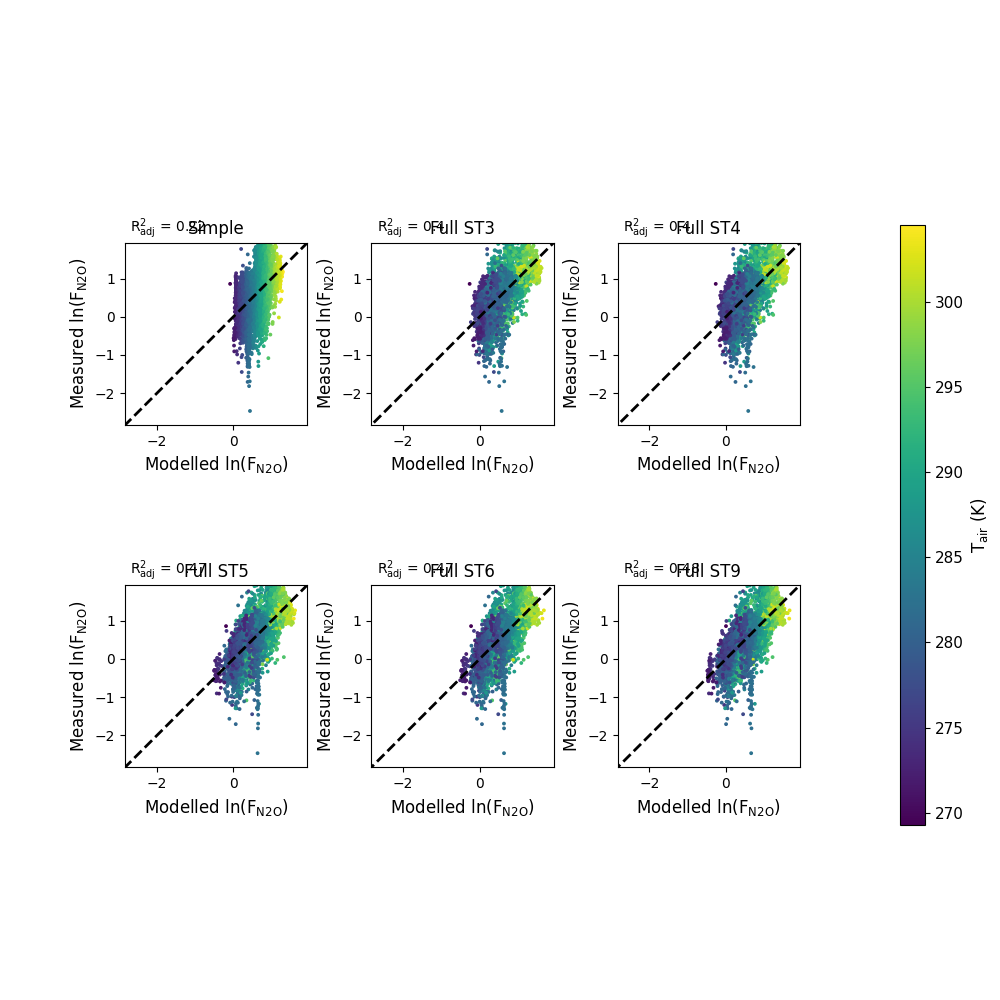

In [11]:
nps = [2, 9, 11, 13, 15, 21]  # Number of parameters in each model
sts = [-1, 3, 4, 5, 6, 9]  # Number of surface types
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
fig.subplots_adjust(wspace=0.35, right=0.8, hspace=-0.2)
axs = axs.flatten()
# axs_to_use = [0, 1, 2, 4, 5, 6, 8]
# axs_to_del = [3, 7, 9, 10, 11]
# for ax_ind in axs_to_del:
#     axs[ax_ind].remove()

for i, model in enumerate(models_n2o):
    obs = model['data'].F_N2O_ln.values
    if model_names[i].split()[0] == 'Simple':
        model_data = simple_model_eq(model['model'].T_air.eval(
        ), model['map'], np.arange(model['data'].shape[0]))
    elif model_names[i].split()[0] == 'Full':
        st_data = return_st_df(sts[i])
        model_data = full_model_eq(model['model'].T_air.eval(
        ), st_data.values, model['map'], np.arange(model['data'].shape[0]))

    xlabel = 'ln(F$_{\mathrm{N2O}}$)'
    ylabel = 'ln(F$_{\mathrm{N2O}}$)'

    color_var = model['data'].T_air_K.values
    cb_label = 'T$_{\mathrm{air}}$ (K)'

    fs = 12
    ls = 10
    im = plot_model_meas_and_r2_adj(
        model_data, obs, nps[i], axs[i], xlabel, ylabel, fs, ls, color_var, cb_label)

    axs[i].set_title(model_names[i], fontsize=fs)

cbar_ax = fig.add_axes([0.9, 0.175, 0.025, 0.6])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('T$_{\mathrm{air}}$ (K)', fontsize=fs)
cb.ax.tick_params(labelsize=fs-1)

# CH<sub>4</sub>

## Load models

In [12]:
with open('models/simple_model_ch4_mutable.pkl', 'rb') as buff:
    simple_ch4 = cloudpickle.load(buff)

with open('models/full_model_ch4_st3_mutable.pkl','rb') as buff:
    full_ch4_st3 = cloudpickle.load(buff)

with open('models/full_model_ch4_st4_mutable.pkl','rb') as buff:
    full_ch4_st4 = cloudpickle.load(buff)

with open('models/full_model_ch4_st5_mutable.pkl','rb') as buff:
    full_ch4_st5 = cloudpickle.load(buff)

with open('models/full_model_ch4_st6_mutable.pkl','rb') as buff:
    full_ch4_st6 = cloudpickle.load(buff)

with open('models/full_model_ch4_st9_mutable.pkl','rb') as buff:
    full_ch4_st9 = cloudpickle.load(buff)

# Load data

In [13]:
data_n2o = pd.read_csv('data/inference_data_n2o.csv', index_col='time')
data_n2o.index = pd.to_datetime(data_n2o.index)

data_ch4 = pd.read_csv('data/inference_data_ch4.csv', index_col='time')
data_ch4.index = pd.to_datetime(data_ch4.index)

In [14]:
# For CH4 remove the two datapoint ln(CH4) ~= -7.1 & -4.4 as this makes produces warning in model comparison stage

data_ch4 = data_ch4.loc[data_ch4.F_CH4_ln > -4.1, :]

## Define surface types dataframes

In [15]:
data = full_ch4_st9['data']
st_3_ch4 = data.loc[:, ['Exposed peat','All ditches','Residue, ground and vegetation']]
st_5_ch4 = data.loc[:, ['Exposed peat','All ditches','Logging residue','Light moss','Green vegetation and trees']]
st_9_ch4 = data.loc[:, ['Fallen tree', 'Dry branch', 'Exposed peat', 'Light moss', 'Dark moss', 'Green vegetation', 'Ditch', 'Tree', 'Covered ditch',]]
st_6_ch4 = data.loc[:, ['Exposed peat','Ditch','Covered ditch','Logging residue','Light moss','Green vegetation and trees']]
st_4_ch4 = data.loc[:, ['Exposed peat','Ditch','Covered ditch','Residue, ground and vegetation']]

def return_st_df(num_st):
    if num_st == 3:
        return st_3_ch4
    elif num_st == 5:
        return st_5_ch4
    elif num_st == 9:
        return st_9_ch4
    elif num_st == 4:
        return st_4_ch4
    elif num_st == 6:
        return st_6_ch4
    else:
        return None

## Put all models to list

In [16]:
models_ch4 = [simple_ch4, full_ch4_st3, full_ch4_st4, full_ch4_st5, full_ch4_st6, full_ch4_st9]
model_names = ["Simple", "Full ST3", "Full ST4", "Full ST5", "Full ST6", "Full ST9"]

## Compute log-likelihood

In [17]:
for model in models_ch4:
    with model["model"]:
        pm.compute_log_likelihood(model["model_res"])

## Create dictionary of model traces

In [18]:
traces = [model['model_res'] for model in models_ch4]
models_dict = {model_name: trace for (model_name, trace) in zip(model_names, traces)}

In [19]:
df_comp_loo = az.compare(models_dict)
df_comp_loo

/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Full ST6,0,2634.482790,13.761109,0.000000,0.549458,121.840222,0.000000,False,log
Full ST9,1,2634.023779,16.832913,0.459012,0.426961,121.894004,2.604907,False,log
Full ST4,2,2617.568462,11.735215,16.914329,0.005662,120.701939,6.115566,False,log
Full ST5,3,2589.577781,12.979241,44.905010,0.000000,117.982905,8.731893,False,log
Full ST3,4,2584.290999,10.318210,50.191791,0.000000,116.888162,10.489201,False,log
Simple,5,2445.996258,6.998132,188.486532,0.017919,112.451768,18.269939,False,log


0.4065
0.4382
0.4457
0.4397
0.4496
0.45


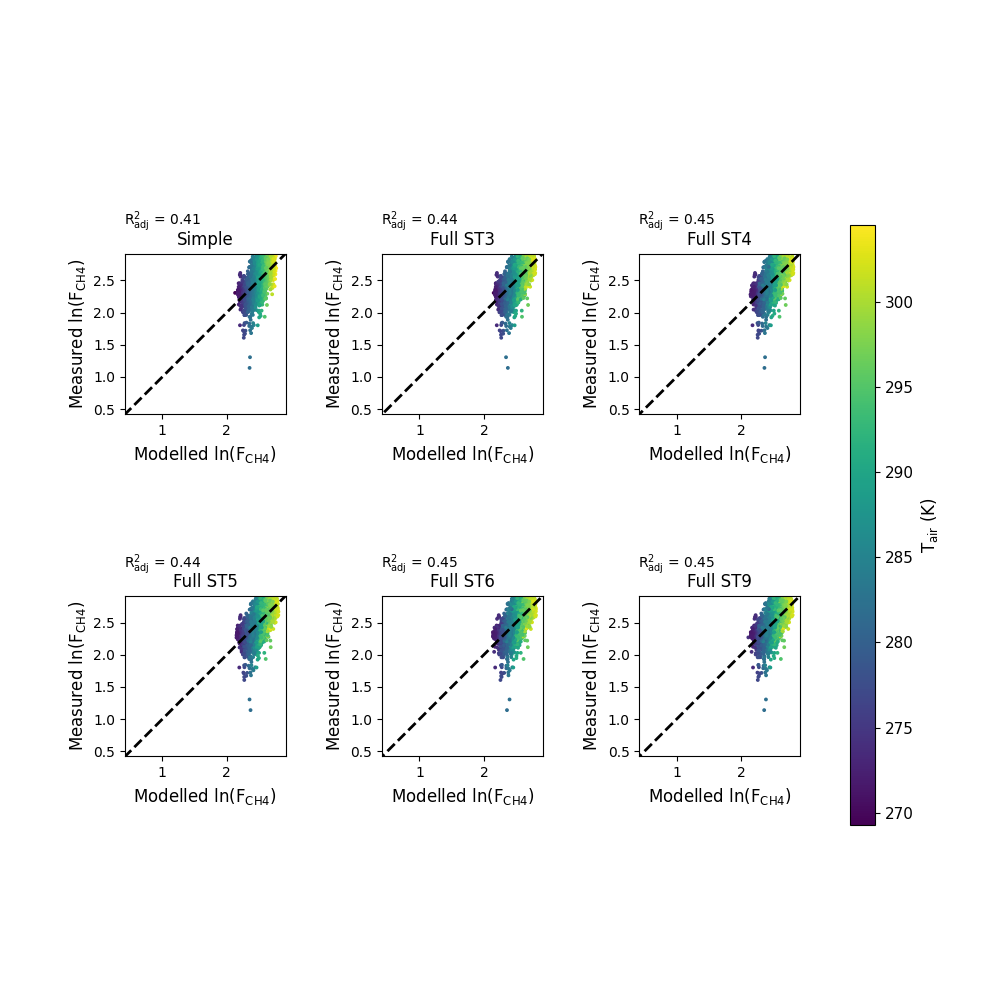

In [20]:
nps = [2, 9, 11, 13, 15, 21] #Number of parameters in each model
sts = [-1, 3, 4, 5, 6, 9] # Number of surface types
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,10))
fig.subplots_adjust(wspace=0.6, right=0.8, hspace=-0.2)
axs = axs.flatten()

for i,model in enumerate(models_ch4):
    obs = model['data'].F_CH4_ln.values
    if model_names[i].split()[0] == 'Simple':
        model_data = simple_model_eq(model['model'].T_air.eval(), model['map'], np.arange(model['data'].shape[0]))
    elif model_names[i].split()[0] == 'Full':
        st_data = return_st_df(sts[i])
        model_data = full_model_eq(model['model'].T_air.eval(), st_data.values, model['map'], np.arange(model['data'].shape[0]))

    xlabel = 'ln(F$_{\mathrm{CH4}}$)'
    ylabel = 'ln(F$_{\mathrm{CH4}}$)'

    color_var = model['data'].T_air_K.values
    cb_label = 'T$_{\mathrm{air}}$ (K)'

    fs = 12
    ls = 10
    im = plot_model_meas_and_r2_adj(model_data, obs, nps[i], axs[i], xlabel, ylabel, fs, ls, color_var, cb_label)

    axs[i].set_title(model_names[i], fontsize=fs)

cbar_ax = fig.add_axes([0.85, 0.175, 0.025, 0.6])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('T$_{\mathrm{air}}$ (K)', fontsize=fs)
cb.ax.tick_params(labelsize=fs-1)

## Load observational data

Data is used to extract the corred order of soil types

In [21]:
ONEDRIVE_FOLDER = os.getenv('ONEDRIVE_FOLDER')

In [22]:
data = xr.open_dataset(f'{ONEDRIVE_FOLDER}/ec_biomet_wtd_2022_footprints_nan_all_times.nc')

In [23]:
soil_classes = data.soil_class.to_numpy()

# Set new surface type names for the best models

In [24]:
full_n2o_st9['model_res'].posterior.st

<xarray.DataArray 'st' (st: 9)>
array(['Fallen tree', 'Dry branch', 'Exposed peat', 'Light moss', 'Dark moss',
       'Green vegetation', 'Ditch', 'Tree', 'Covered ditch'], dtype='<U16')
Coordinates:
  * st       (st) <U16 'Fallen tree' 'Dry branch' ... 'Tree' 'Covered ditch'

In [25]:
full_ch4_st6['model_res'].posterior.st

<xarray.DataArray 'st' (st: 6)>
array(['Exposed peat', 'Ditch', 'Covered ditch', 'Logging residue',
       'Light moss', 'Green vegetation and trees'], dtype='<U26')
Coordinates:
  * st       (st) <U26 'Exposed peat' 'Ditch' ... 'Green vegetation and trees'

In [26]:
new_st_9 = np.array(['Dead wood','Harvest residue','Exposed peat','Litter','Bottom layer (mosses)','Field layer','Ditch (water surface)', 'Living tree', 'Plant covered ditch'])
new_st_6 = np.array(['Exposed peat', 'Ditch (water surface)', 'Plant covered ditch', 'Dead wood and residue', 'Litter', 'Field layer and trees',])

full_ch4_st6['model_res']['posterior']['st'] = new_st_6

full_n2o_st9['model_res']['posterior']['st'] = new_st_9

In [27]:
st_6_ch4.columns

Index(['Exposed peat', 'Ditch', 'Covered ditch', 'Logging residue',
       'Light moss', 'Green vegetation and trees'],
      dtype='object')

In [28]:
st_9_n2o = st_9_n2o.rename(columns = {i:j for i,j in zip(st_9_n2o.columns, new_st_9)})
st_6_ch4 = st_6_ch4.rename(columns = {i:j for i,j in zip(st_6_ch4.columns, new_st_6)})

# Print parameter values for the best models

In [29]:
n2o_params = az.hdi(full_n2o_st9['model_res'],var_names=["alpha", "beta", "gamma", "delta"], hdi_prob = 0.95)

In [30]:
ch4_params = az.hdi(full_ch4_st6['model_res'],var_names=["alpha", "beta", "gamma", "delta"], hdi_prob = 0.95)

In [31]:
n2o_alpha = {'Parameter': 'alpha N2O', 'Value' :f'{np.round(n2o_params.alpha.values[0],3)} - {np.round(n2o_params.alpha.values[1],3)}'}
ch4_alpha = {'Parameter': 'alpha CH4', 'Value' : f'{np.round(ch4_params.alpha.values[0],3)} - {np.round(ch4_params.alpha.values[1],3)}'}

In [32]:
n2o_beta = {'Parameter': 'beta N2O','Value' :f'{np.round(n2o_params.beta.values[0],3)} - {np.round(n2o_params.beta.values[1],3)}'}
ch4_beta = {'Parameter': 'beta CH4', 'Value' : f'{np.round(ch4_params.beta.values[0],3)} - {np.round(ch4_params.beta.values[1],3)}'}

In [33]:
n2o_gamma = {k:f'{np.round(lower,3)} - {np.round(upper,3)}' for k,lower,upper in zip(st_9_n2o.columns.to_list(), n2o_params.gamma.values[:, 0], n2o_params.gamma.values[:, 1])}
ch4_gamma = {k:f'{np.round(lower,3)} - {np.round(upper,3)}' for k,lower,upper in zip(st_6_ch4.columns.to_list(), ch4_params.gamma.values[:, 0], ch4_params.gamma.values[:, 1])}

In [34]:
n2o_delta = {k:f'{np.round(lower,3)} - {np.round(upper,3)}' for k,lower,upper in zip(st_9_n2o.columns.to_list(), n2o_params.delta.values[:, 0], n2o_params.delta.values[:, 1])}
ch4_delta = {k:f'{np.round(lower,3)} - {np.round(upper,3)}' for k,lower,upper in zip(st_6_ch4.columns.to_list(), ch4_params.delta.values[:, 0], ch4_params.delta.values[:, 1])}

In [35]:
n2o_dicts = [n2o_gamma, n2o_delta]
parameters = ['gamma N2O', 'delta N2O']
for i,d in enumerate(n2o_dicts):
    items = list(d.items())
    items.insert(0, ('Parameter', parameters[i]))
    d = dict(items)
    d['Dead wood and residue'] = '-'
    d['Field layer and trees'] = '-'
    d['Value'] = '-'
    n2o_dicts[i] = d

n2o_gamma = n2o_dicts[0]
n2o_delta = n2o_dicts[1]

In [36]:
ch4_dicts = [ch4_gamma, ch4_delta]
parameters = ['gamma ch4', 'delta ch4']
for i,d in enumerate(ch4_dicts):
    items = list(d.items())
    items.insert(0, ('Parameter', parameters[i]))
    d = dict(items)
    d['Dead wood'] = '-'
    d['Harvest residue'] = '-'
    d['Field layer'] = '-'
    d['Living tree'] = '-'
    d['Bottom layer (mosses)'] = '-'
    d['Value'] = '-'
    ch4_dicts[i] = d

ch4_gamma = ch4_dicts[0]
ch4_delta = ch4_dicts[1]

In [37]:
dicts = [n2o_alpha, n2o_beta, ch4_alpha, ch4_beta]

for i,d in enumerate(dicts):
    d['Ditch (water surface)'] = '-'
    d['Exposed peat'] = '-'
    d['Dead wood'] = '-'
    d['Harvest residue'] = '-'
    d['Litter'] = '-'
    d['Living tree'] = '-'
    d['Field layer'] = '-'
    d['Bottom layer (mosses)'] = '-'
    d['Plant covered ditch'] = '-'
    d['Dead wood and residue'] = '-'
    d['Field layer and trees'] = '-'
    

n2o_alpha = dicts[0]
n2o_beta = dicts[1]
ch4_alpha = dicts[2]
ch4_beta = dicts[3]

In [38]:
st_data = [
    n2o_alpha, ch4_alpha, n2o_beta, ch4_beta, n2o_gamma, ch4_gamma, n2o_delta, ch4_delta
]

In [39]:
print(markdown_table(st_data).get_markdown())

```
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Parameter|     Value    |Ditch (water surface)| Exposed peat|  Dead wood  |Harvest residue|    Litter   | Living tree |  Field layer  |Bottom layer (mosses)|Plant covered ditch|Dead wood and residue|Field layer and trees|
+---------+--------------+---------------------+-------------+-------------+---------------+-------------+-------------+---------------+---------------------+-------------------+---------------------+---------------------+
|alpha N2O|-1.007 - 0.624|          -          |      -      |      -      |       -       |      -      |      -      |       -       |          -          |         -         |          -          |          -          |
+---------+--------------+---------------------+-------------+-------------+---------------+------------

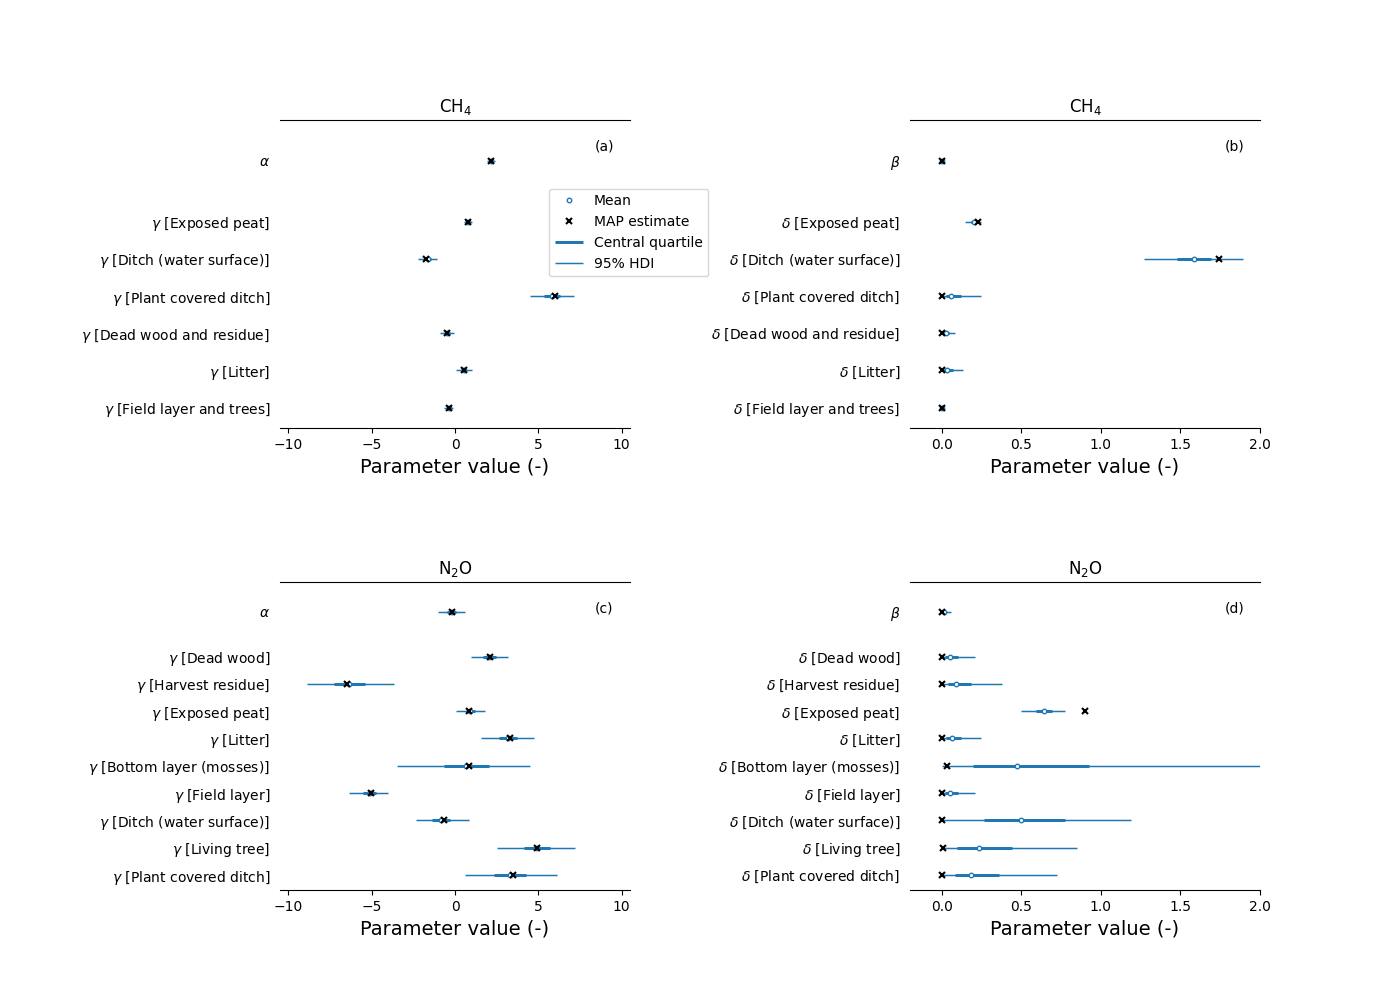

In [56]:
fig, axs = plt.subplots(figsize=(14,10), nrows=2, ncols=2)
axs = axs.flatten()
fig.subplots_adjust(left=0.2, wspace=0.8, hspace=0.5)

map_markersize=4

az.plot_forest(
    full_ch4_st6['model_res'], var_names=["alpha", "gamma"], hdi_prob=0.95, r_hat=False, combined=True, textsize=10, ax=axs[0],
)
axs[0].set_xlim([-10.5, 10.5])
axs[0].set_xlabel(r'Parameter value (-)', fontsize=14)
yticks = axs[0].get_yticks()
map_values = full_ch4_st6['map']

vals = list(map_values.values())
keys = list(map_values.keys())
alpha_gamma_vals = np.flip(np.concatenate([np.atleast_1d(vals[keys.index(i)]) for i in ['alpha','gamma']]))

axs[0].plot(alpha_gamma_vals, yticks, 'kx',markersize=map_markersize, markeredgewidth=1.5, label='MAP estimate')

az.plot_forest(
    full_ch4_st6['model_res'], var_names=["beta", "delta"], hdi_prob=0.95, r_hat=False, combined=True, textsize=10, ax=axs[1],
)

axs[1].set_xlim([-0.2, 2])
axs[1].set_xlabel(r'Parameter value (-)', fontsize=14)

yticks = axs[1].get_yticks()
map_values = full_ch4_st6['map']

vals = list(map_values.values())
keys = list(map_values.keys())
alpha_gamma_vals = np.flip(np.concatenate([np.atleast_1d(vals[keys.index(i)]) for i in ['beta','delta']]))

axs[1].plot(alpha_gamma_vals, yticks, 'kx',markersize=map_markersize, markeredgewidth=1.5)

az.plot_forest(
    full_n2o_st9['model_res'], var_names=["alpha", "gamma"], hdi_prob=0.95, r_hat=False, combined=True, textsize=10, ax=axs[2]
)

axs[2].set_xlim([-10.5, 10.5])
axs[2].set_xlabel(r'Parameter value (-)', fontsize=14)

yticks = axs[2].get_yticks()
map_values = full_n2o_st9['map']

vals = list(map_values.values())
keys = list(map_values.keys())
alpha_gamma_vals = np.flip(np.concatenate([np.atleast_1d(vals[keys.index(i)]) for i in ['alpha','gamma']]))

axs[2].plot(alpha_gamma_vals, yticks, 'kx',markersize=map_markersize, markeredgewidth=1.5)

az.plot_forest(
    full_n2o_st9['model_res'], var_names=["beta", "delta"], hdi_prob=0.95, r_hat=False, combined=True, textsize=10, ax=axs[3],
)
axs[3].set_xlim([-0.2, 2])
axs[3].set_xlabel(r'Parameter value (-)', fontsize=14)

yticks = axs[3].get_yticks()
map_values = full_n2o_st9['map']

vals = list(map_values.values())
keys = list(map_values.keys())
alpha_gamma_vals = np.flip(np.concatenate([np.atleast_1d(vals[keys.index(i)]) for i in ['beta','delta']]))

axs[3].plot(alpha_gamma_vals, yticks, 'kx',markersize=map_markersize, markeredgewidth=1.5, label='MAP estimate')

for ax in axs[[0,2]]:
    yticklabels = ax.get_yticklabels()
    for label in yticklabels:
        new_text = label.get_text()
        if 'gamma' in label.get_text():
            new_text = new_text.replace('gamma', r'$\gamma$ ')
        elif 'gamma' not in label.get_text() and label.get_text() != 'alpha':
            new_text = r'$\gamma$ ' + new_text
        elif label.get_text() == 'alpha':
            new_text = r'$\alpha$'
        #new_text = new_text.replace('[', '(').replace(']',')')
        label.set_text(new_text)
    ax.set_yticklabels(yticklabels)

for ax in axs[[1,3]]:
    yticklabels = ax.get_yticklabels()
    for label in yticklabels:
        new_text = label.get_text()
        if 'delta' in label.get_text():
            new_text = new_text.replace('delta', r'$\delta$ ')
        elif 'gamma' not in label.get_text() and label.get_text() != 'beta':
            new_text = r'$\delta$ ' + new_text
        elif label.get_text() == 'beta':
            new_text = r'$\beta$'
        #new_text = new_text.replace('[', '(').replace(']',')')
        label.set_text(new_text)
    ax.set_yticklabels(yticklabels)

subplot_labels = ['(a)','(b)','(c)','(d)']
titles = ['CH$_4$', 'CH$_4$','N$_2$O','N$_2$O']
for i,ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.text(0.9, 0.9, subplot_labels[i], transform=ax.transAxes)

# Add legend

axs[0].lines[0].set_label('Mean')
axs[0].collections[11].set_label('Central quartile')
axs[0].collections[0].set_label('95% HDI')

h, l  = axs[0].get_legend_handles_labels()

h = [h[1], h[-1], h[-2], h[0]]
l = [l[1], l[-1], l[-2], l[0]]
axs[0].legend(h,l, bbox_to_anchor=(0.75, 0.8))

# Plot best model performance metrics

## Visualization function

In [41]:
def visualize_fit(model, obs, posterior, model_color, xlabel, ylabel, color_var=None,num_bins=10, cb_label='', axs=None):
    # NB! These works only for negative values of model and obs
    # Figure definitions
    if axs is None:
        fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
        axs = axs.flatten()
        fig.subplots_adjust(bottom=0.2, hspace=0.3, wspace=0.5)
    fs=14
    ls=10

    # Find min and max value between model and measurements

    if np.min(model) < model.min():
        min_all = np.min(model)
    else:
        min_all = obs.min()
    min_all = min_all*1.15

    if np.max(model) > model.max():
        max_all = np.max(model)
    else:
        max_all = obs.max()
    max_all = max_all*0.85

    # Fig. 1
    axs[0].plot(obs.index, obs, 'o', markersize=4, markeredgecolor='k', markeredgewidth=0.5, color='w', label='Measured')
    axs[0].plot(obs.index, model, 'o', color=model_color, markeredgecolor='k', markeredgewidth=0.5, markersize=4, label='MAP estimate', alpha=.50)

    axs[0].set_ylabel(ylabel, fontsize=fs)

    axs[0].tick_params(axis='both', labelsize=ls)
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
    axs[0].legend(loc='upper left', prop={'size': ls}, bbox_to_anchor=(0.1, 1.2))


    # Fig. 2
    az.plot_ppc(posterior, num_pp_samples=1000, ax=axs[1])
    axs[1].set_xlabel(xlabel, fontsize=fs)
    axs[1].tick_params(axis='both', labelsize=ls)
    axs[1].legend(loc='upper left', prop={'size': ls}, bbox_to_anchor=(0.1, 1.3))

    # Fig. 3
    r2 = r2_score(obs.values, model)
    rmse = mean_squared_error(obs.values, model)
    if color_var is not None:
        im = axs[2].scatter(model, obs, c=color_var, s=3)
        cb = fig.colorbar(im)
        cb.set_label('T$_{\mathrm{air}}$ (K)', fontsize=fs)
        cb.ax.tick_params(labelsize=fs-1)
    else:
        im = axs[2].scatter(model, obs, c='gray', s=3)

    axs[2].set_xlabel(f'Modelled {ylabel}', fontsize=fs)
    axs[2].set_ylabel(f'Measured {xlabel}', fontsize=fs)
    axs[2].tick_params(axis='both', labelsize=ls)
    axs[2].text(min_all*0.95, max_all * 1.15, f'R$^2$ = {np.round(r2, 2)}', fontsize=ls)

    axs[2].text(min_all*0.95, max_all * 1.20, f'RMSE = {np.round(rmse, 5)}', fontsize=ls)
    axs[2].set_xlim(min_all, max_all)
    axs[2].set_ylim(min_all, max_all)
    axs[2].plot((-15,15), (-15,15), 'k--', linewidth=2)
    axs[2].set_aspect('equal')

    # Fig. 4
    num_bins = 10
    color_var_bins = np.linspace(np.min(color_var)-1, np.max(color_var)+1, num_bins)

    ind = np.digitize(color_var, color_var_bins)
    res = obs-model
    means = np.zeros((num_bins,))
    stds = np.zeros_like(means)
    for i in range(num_bins):
        ind_this_bin = np.where(ind==i+1)[0]
        vals = res.iloc[ind_this_bin]
        means[i] = np.mean(vals)
        stds[i] = np.std(vals)
    jet = mpl.colormaps.get_cmap('jet')

    color_var_bins_means = color_var_bins[:-1] + (color_var_bins[1:]-color_var_bins[:-1])/2
    axs[3].bar(color_var_bins_means, means[:-1], width=3, color=jet(np.linspace(0,1,num_bins)))
    axs[3].errorbar(color_var_bins_means, means[:-1], stds[:-1], fmt='.', color='Black', elinewidth=1,capthick=1, ms=0, capsize = 3)

    axs[3].set_ylabel('MAP residuals', fontsize=fs)
    axs[3].set_xlabel(cb_label, fontsize=fs)

    subplot_labels = ['(a)','(b)','(c)','(d)']
    for i,ax in enumerate(axs):
        ax.text(0.05, 0.95, subplot_labels[i], transform=ax.transAxes, fontsize=ls)


In [42]:
def visualize_fit_real(model, obs, posterior, model_color, xlabel, ylabel, color_var=None,num_bins=10, cb_label='', scatter_ticks=None, axs=None):
    # This version: fluxes in real units (nmol /m2 /s)
    # NB! These works only for positive values of model and obs
    # Figure definitions
    if axs is None:
        fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
        axs = axs.flatten()
        fig.subplots_adjust(bottom=0.2, hspace=0.3, wspace=0.5)
    fs=14
    ls=10

    # Find min and max value between model and measurements

    if np.min(model) < model.min():
        min_all = np.min(model)
    else:
        min_all = obs.min()
    min_all = min_all*0.85

    if np.max(model) > model.max():
        max_all = np.max(model)
    else:
        max_all = obs.max()
    max_all = max_all*1.15

    # Fig. 1
    axs[0].plot(obs.index, obs, 'o', markersize=4, markeredgecolor='k', markeredgewidth=0.75, color='w', label='Measured')
    axs[0].plot(obs.index, model, 'o', color=model_color, markeredgecolor='k', markeredgewidth=0.25, markersize=4, label='MAP estimate',)

    axs[0].set_ylabel(ylabel, fontsize=fs)

    axs[0].tick_params(axis='both', labelsize=ls)
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
    axs[0].legend(loc='upper left', prop={'size': ls}, bbox_to_anchor=(0.1, 1.2))

    xmin, xmax = axs[0].get_xlim()
    axs[0].plot((datetime(2022,1,1), datetime(2022,12,31)), (0,0), 'k--', linewidth=2)
    axs[0].set_xlim((xmin, xmax))


    # Fig. 2
    az.plot_ppc(posterior, num_pp_samples=1000, ax=axs[1])
    compound = xlabel.split(' ')[0].split('{')[-1].split('}')[0]
    axs[1].set_xlabel(f'ln(F$_{{\mathrm{{{compound}}}}}$)', fontsize=fs)
    axs[1].tick_params(axis='both', labelsize=ls)
    axs[1].legend(loc='upper left', prop={'size': ls}, bbox_to_anchor=(0.1, 1.3))

    # Fig. 3
    r2 = r2_score(obs.values, model)
    rmse = mean_squared_error(obs.values, model)
    if color_var is not None:
        im = axs[2].scatter(model, obs, c=color_var, s=3, vmin=np.min(color_var), vmax=np.max(color_var))
        cb = fig.colorbar(im)
        cb.set_label(cb_label, fontsize=fs)
        cb.ax.tick_params(labelsize=fs-1)
    else:
        im = axs[2].scatter(model, obs, c='gray', s=3)

    axs[2].set_xlabel(f'Modelled {ylabel}', fontsize=fs)
    axs[2].set_ylabel(f'Measured {xlabel}', fontsize=fs)
    axs[2].tick_params(axis='both', labelsize=ls)
    axs[2].text(0.5, 0.2, f'R$^2$ = {np.round(r2, 2)}', fontsize=ls, transform=axs[2].transAxes)

    axs[2].text(0.5, 0.15, f'RMSE = {np.round(rmse, 5)}', fontsize=ls, transform=axs[2].transAxes)
    axs[2].set_xlim(min_all, max_all)
    axs[2].set_ylim(min_all, max_all)
    axs[2].plot((-30,30), (-30,30), 'k--', linewidth=2)
    axs[2].set_aspect('equal')
    if scatter_ticks is not None:
        axs[2].set_xticks(scatter_ticks)
        axs[2].set_yticks(scatter_ticks)
    else:
        yticks = axs[2].get_yticks()
        xticks = axs[2].get_xticks()
        if yticks.shape[0] < xticks.shape[0]:
            axs[2].set_xticks(yticks)
        else:
            axs[2].set_yticks(xticks)

    # Fig. 4

    color_var_bins = np.linspace(np.min(color_var)-1, np.max(color_var)+1, num_bins)

    ind = np.digitize(color_var, color_var_bins)
    res = obs-model
    means = np.zeros((num_bins,))
    stds = np.zeros_like(means)
    for i in range(num_bins):
        ind_this_bin = np.where(ind==i+1)[0]
        vals = res.iloc[ind_this_bin]
        means[i] = np.mean(vals)
        stds[i] = np.std(vals)
    jet = mpl.colormaps.get_cmap('viridis')

    color_var_bins_means = color_var_bins[:-1] + (color_var_bins[1:]-color_var_bins[:-1])/2
    axs[3].bar(color_var_bins_means, means[:-1], width=3, color=jet(np.linspace(0,1,num_bins)))
    axs[3].errorbar(color_var_bins_means, means[:-1], stds[:-1], fmt='.', color='Black', elinewidth=1,capthick=1, ms=0, capsize = 3)

    axs[3].set_ylabel('MAP residuals', fontsize=fs)
    axs[3].set_xlabel(cb_label, fontsize=fs)
    xmin, xmax = axs[3].get_xlim()
    axs[3].plot((-100,400), (0,0), 'k--', linewidth=2)
    axs[3].set_xlim((xmin,xmax))

    # Alternative Fig. 4, residual time series, color by T
    # res = obs-model
    # cmap = mpl.colormaps.get_cmap('viridis')

    # norm = mpl.colors.Normalize(vmin=np.min(color_var), vmax=np.max(color_var))
    # axs[3].scatter(obs.index, res, s=6, c=color_var, vmin=np.min(color_var), vmax=np.max(color_var))
    subplot_labels = ['(a)','(b)','(c)','(d)']

    for i,ax in enumerate(axs):
        ax.text(0.05, 0.95, subplot_labels[i], transform=ax.transAxes, fontsize=ls)


/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


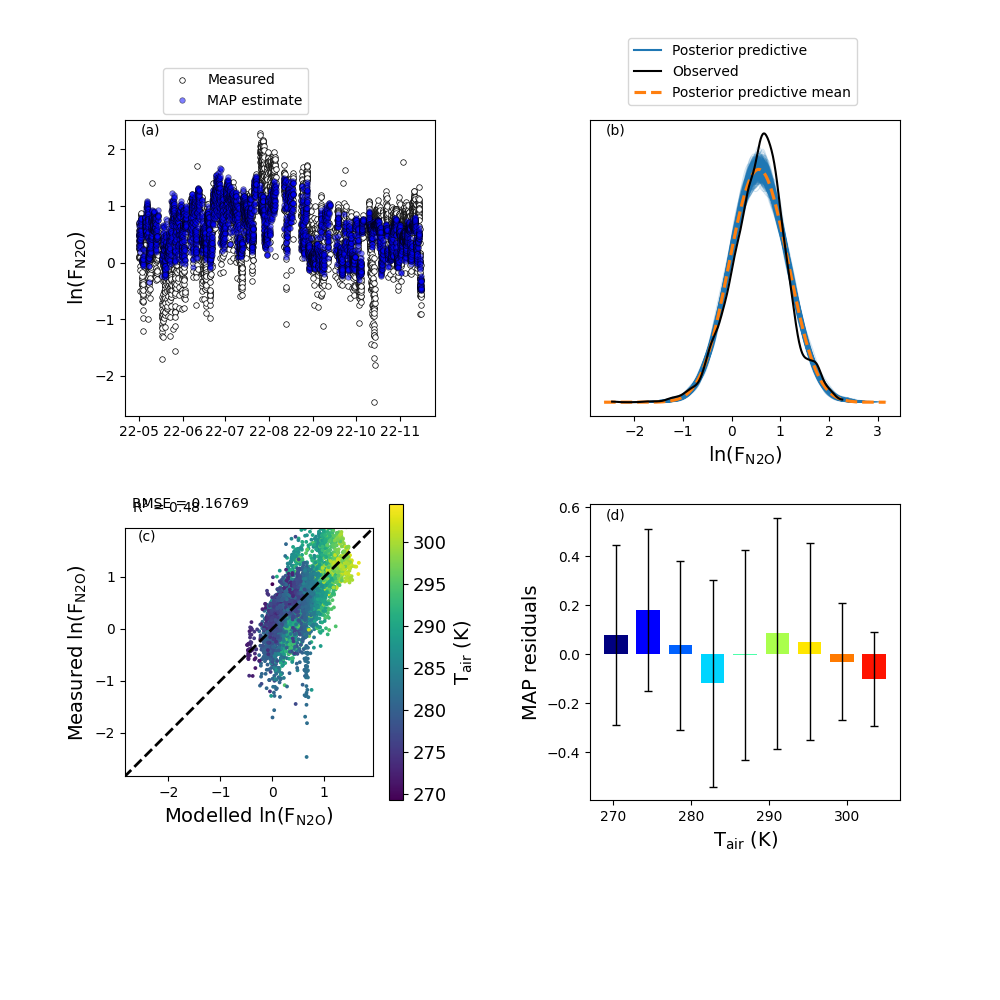

In [43]:
model = full_model_eq(full_n2o_st9['model']['T_air'].eval(), st_9_n2o.values, full_n2o_st9['map'], np.arange(data_n2o.shape[0]))
obs = data_n2o.loc[:, 'F_N2O_ln']

posterior = full_n2o_st9['model_res']

xlabel = 'ln(F$_{\mathrm{N2O}}$)'
ylabel = 'ln(F$_{\mathrm{N2O}}$)'

color_var = data_n2o.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, posterior, 'b', xlabel, ylabel, color_var=color_var, num_bins=10, cb_label=cb_label, axs=None)

/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


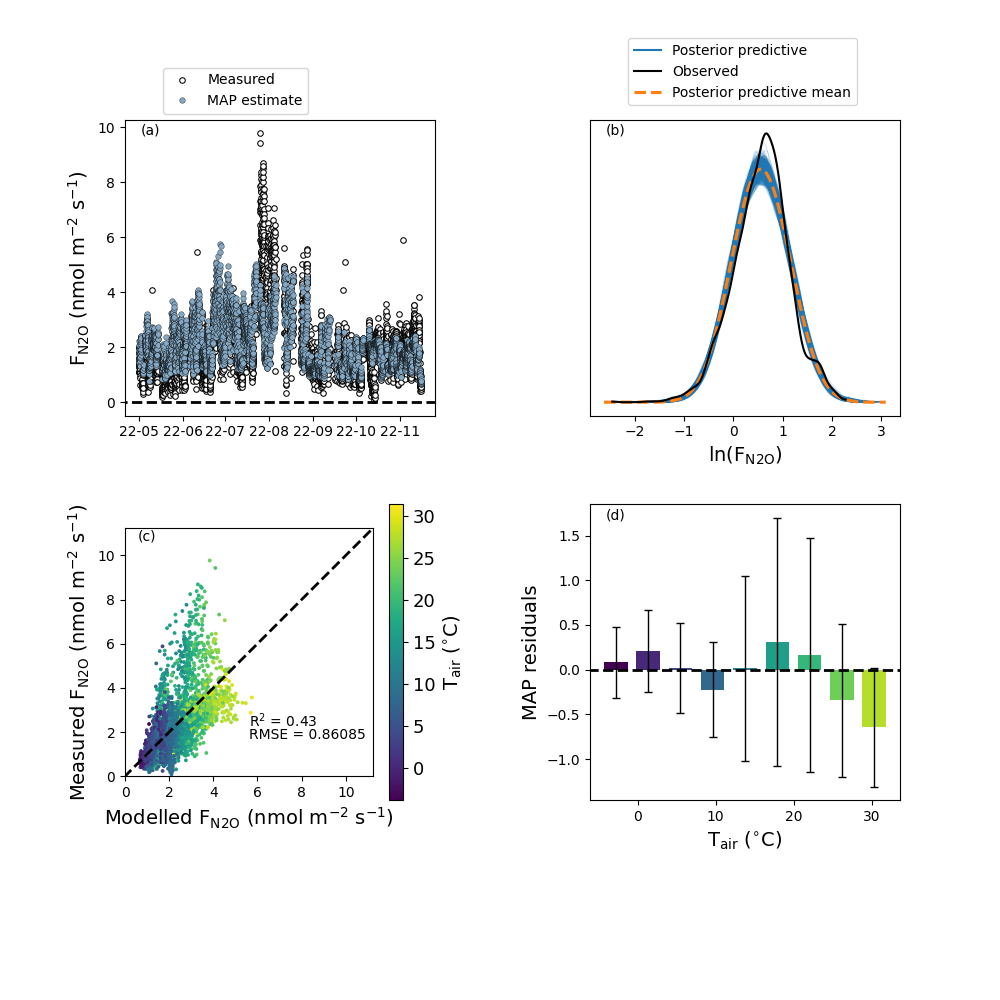

In [44]:
model = full_model_eq(full_n2o_st9['model']['T_air'].eval(), st_9_n2o.values, full_n2o_st9['map'], np.arange(data_n2o.shape[0]))
model = (np.exp(model + full_n2o_st9['map']['sigma'].flatten()[0]**2.0/2.0))
obs = data_n2o.loc[:, 'F_N2O']*1000

posterior = full_n2o_st9['model_res']

xlabel = 'F$_{\mathrm{N2O}}$ (nmol m$^{-2}$ s$^{-1}$)'
ylabel = 'F$_{\mathrm{N2O}}$ (nmol m$^{-2}$ s$^{-1}$)'

color_var = data_n2o.T_air.values
cb_label = 'T$_{\mathrm{air}}$ ($^{\circ}$C)'

scatter_ticks = np.linspace(0, 10, 6)

visualize_fit_real(model, obs, posterior, (0.5200962739223556, 0.6635739143403039, 0.768051194033441, 1.0), xlabel, ylabel, color_var=color_var, num_bins=10, cb_label=cb_label, scatter_ticks = scatter_ticks, axs=None)

/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


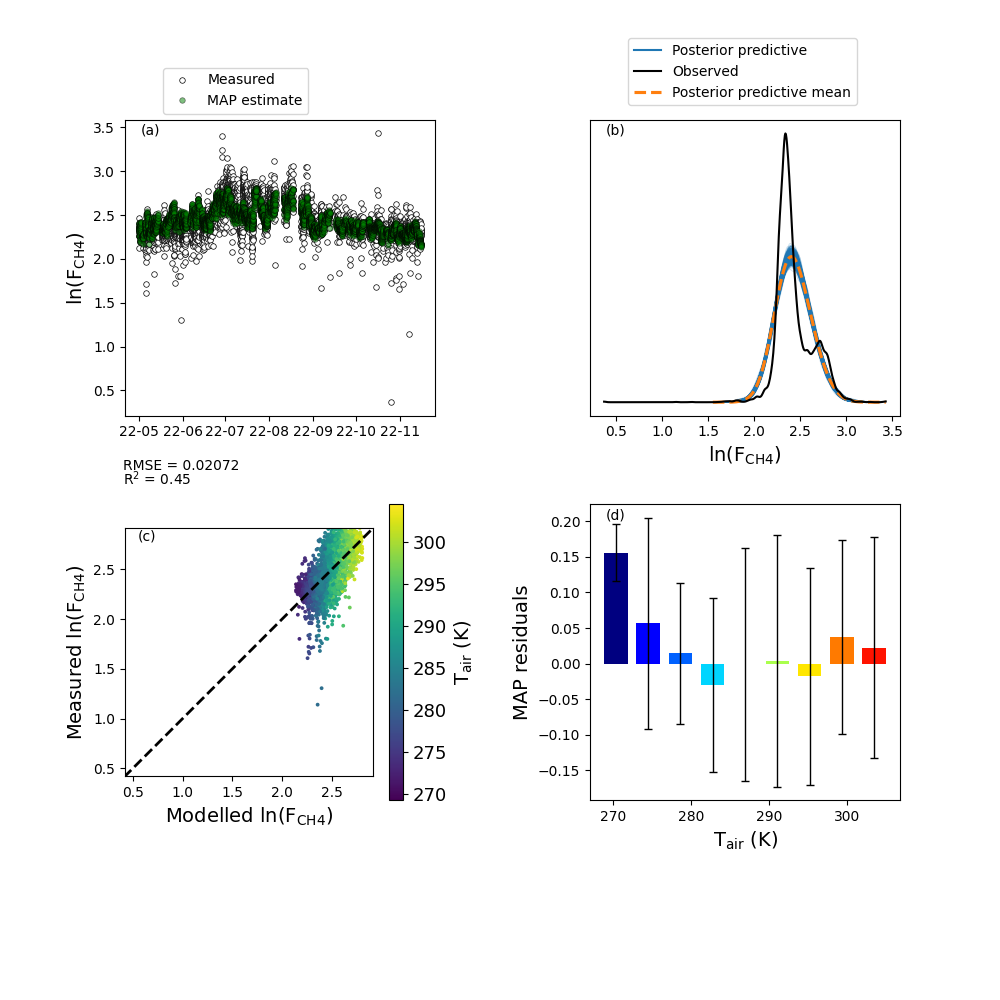

In [45]:
model = full_model_eq(full_ch4_st6['model']['T_air'].eval(), st_6_ch4.values, full_ch4_st6['map'], np.arange(data_ch4.shape[0]))
obs = data_ch4.loc[:, 'F_CH4_ln']

posterior = full_ch4_st9['model_res']

xlabel = 'ln(F$_{\mathrm{CH4}}$)'
ylabel = 'ln(F$_{\mathrm{CH4}}$)'

color_var = data_ch4.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, posterior, 'g', xlabel, ylabel, color_var=color_var, num_bins=10, cb_label=cb_label, axs=None)

In [46]:
np.exp(2.75)

15.642631884188171

/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


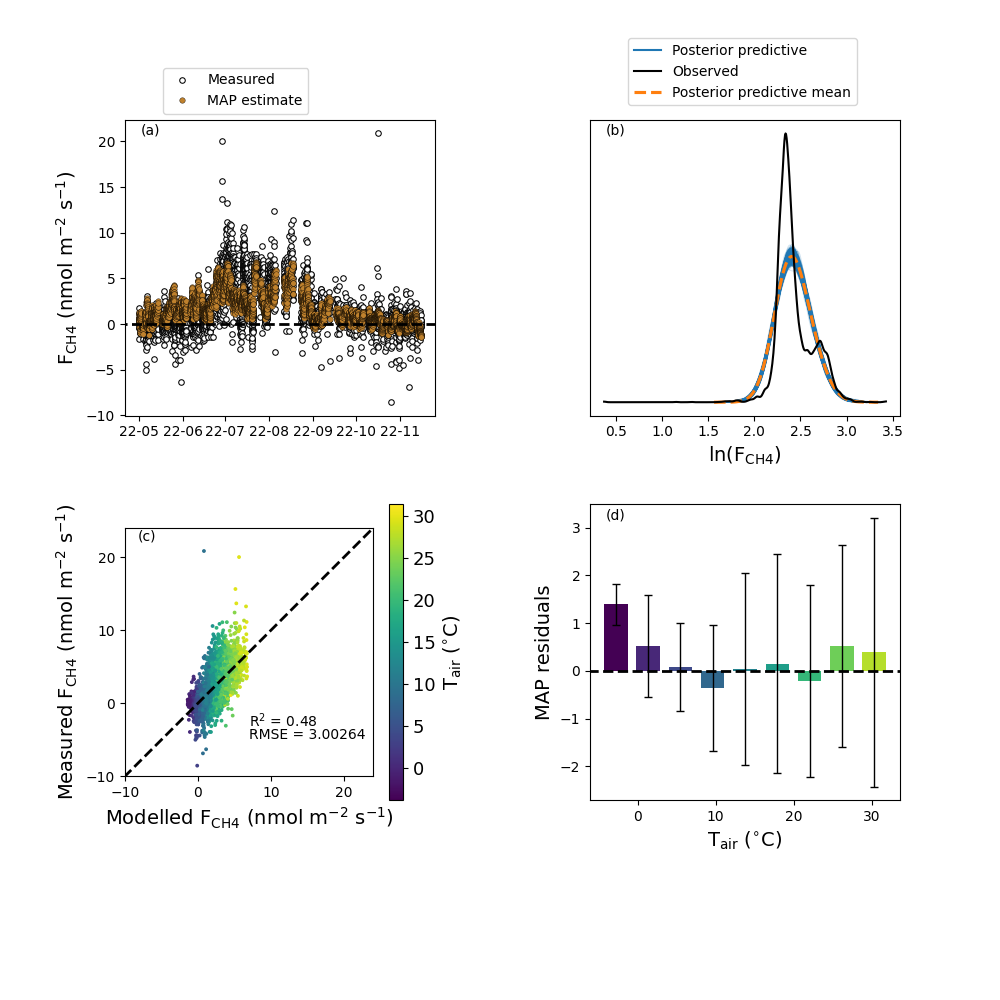

In [47]:
model = full_model_eq(full_ch4_st6['model']['T_air'].eval(), st_6_ch4.values, full_ch4_st6['map'], np.arange(data_ch4.shape[0]))
model = (np.exp(model + full_ch4_st6['map']['sigma'].flatten()[0]**2.0/2.0)-10)

obs = data_ch4.loc[:, 'F_CH4']*1000

posterior = full_ch4_st6['model_res']

xlabel = 'F$_{\mathrm{CH4}}$ (nmol m$^{-2}$ s$^{-1}$)'
ylabel = 'F$_{\mathrm{CH4}}$ (nmol m$^{-2}$ s$^{-1}$)'

color_var = data_ch4.T_air.values
cb_label = 'T$_{\mathrm{air}}$ ($^{\circ}$C)'

scatter_ticks = np.linspace(-10,20, 4)

visualize_fit_real(model, obs, posterior, (0.7490196078431373, 0.5058823529411764, 0.17647058823529413, 1.0), xlabel, ylabel, color_var=color_var, num_bins=10, cb_label=cb_label, scatter_ticks=scatter_ticks, axs=None)